# Введение
●	target_sum – прогнозируемая переменная (объем оборота POS-транзакций клиента в последующие 3 месяца). Для одного клиента cl_id строим один прогноз.

In [98]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score # regression
from sklearn.metrics import accuracy_score # classification

In [99]:
#ser_ts_sum = train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).sum().astype('int64')
#ser_pos_count = train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).count().rename(columns={'target_sum':'count_POS'}).astype('int64')
#ser_notpos_count = train[train['trx_category'] != 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).count().rename(columns={'target_sum':'count_notPOS'}).astype('int64')
#train = train.drop(axis=1, labels='target_sum').join(ser_ts_sum, on=['cl_id', 'year', 'month'], how='left').join(ser_pos_count, on=['cl_id', 'year', 'month'], how='left').join(ser_notpos_count, on=['cl_id', 'year', 'month'], how='left')


'''
[description]
InsertDataFrame - pandas dataframe
ColumnName - name of transforming column
'''
def MakeDateYearMonth(InsertDataFrame, ColumnName):
    df = InsertDataFrame.copy()
    df[ColumnName] = pd.to_datetime(df[ColumnName], dayfirst=True)
    df['year'] = df[ColumnName].dt.year
    df['month'] = df[ColumnName].dt.month
    return df    

'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbysum(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    sdtype = df[TargetColumn].dtype
    ser = df.groupby(by=GroupByList).sum().rename(columns={TargetColumn:TargetName}).astype(sdtype)
    return ser
    
'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbycount(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    ser = df.groupby(by=GroupByList).count().rename(columns={TargetColumn:TargetName}).astype('int64')
    return ser    

'''
[description]
InsertDataFrame - pandas dataframe
SeriesList - list of pandas series
OnJoin - string or list of column name(s)
'''
def DfLeftJoinSer(InsertDataFrame, SeriesList, OnJoin):
    df = InsertDataFrame.copy()
    for i in SeriesList:
        df = df.join(i, on=OnJoin, how='left')
    return df

In [100]:
url_train = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/train.csv'
url_test = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/test.csv'

#train = pd.read_csv(url_train)
#test = pd.read_csv(url_test)

#train = pd.read_csv(r'C:/Course/xsolla/Git/Machine-learning-course-task/train.csv')
#test = pd.read_csv(r'C:/Course\xsolla/Git/Machine-learning-course-task/test.csv')

train = pd.read_csv(r'C:/Course/xsolla/Git/Machine-learning-course-task/train.csv')
test = pd.read_csv(r'C:/Course/xsolla/Git/Machine-learning-course-task/test.csv')

train2 = train.copy()
test2 = test.copy()

In [101]:
train = train2.copy()
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0.0


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_sum      490513 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 33.7+ MB


# Независимые переменные для модели
год, месяц - сколько берём? надо смотреть сколько есть  
количество POS-транзакций  
количество не-POS-транзакций  
сумма POS-транзакций  
сумма не- POS-транзакций

не забываем нормализацию!!!!!

In [103]:
# Входные сырые данные + колонки
train = train[train['currency'] == 810]
train = MakeDateYearMonth(train, 'PERIOD')
group_list = ['cl_id', 'year', 'month']
ser_ts_sum = train[['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).first().astype('float64')
ser_pos_amount_sum = groupbysum(train[train['trx_category'] == 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_pos')
ser_notpos_amount_sum = groupbysum(train[train['trx_category'] != 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_notpos')
ser_pos_count = groupbycount(train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']],
                       group_list,
                       'target_sum',
                       'count_pos')
ser_notpos_count = groupbycount(train[train['trx_category'] != 'POS'][['cl_id', 'target_sum', 'year', 'month']],
                       group_list,
                       'target_sum',
                       'count_notpos')

train = DfLeftJoinSer(train.drop(axis=1, labels=['PERIOD','MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 'target_sum']).drop_duplicates(),
                      [ser_ts_sum, ser_pos_amount_sum, ser_notpos_amount_sum, ser_pos_count, ser_notpos_count],
                      ['cl_id', 'year', 'month'])
train.head()

,cl_id,year,month,target_sum,sum_pos,sum_notpos,count_pos,count_notpos
0,0,2017,10,0.0,7054.00,56562.0,2.0,2.0
2,0,2017,12,0.0,767.00,NaN,1.0,NaN
5,1,2017,10,0.0,11276.30,NaN,15.0,NaN
9,1,2017,7,0.0,3930.26,50000.0,10.0,1.0
11,1,2017,8,0.0,3807.50,NaN,7.0,NaN


In [104]:
# Через промедуточный датафрейм
# train_transformed
train_tf = pd.DataFrame(columns=['cl_id', 'target_sum'])
for i in train.cl_id.unique():
    train_tf = train_tf.append(train[train['cl_id'] == i][['cl_id', 'target_sum']].iloc[0])
train_tf = train_tf.astype({'cl_id': 'int64'})

max_mon = train.groupby('cl_id').count().month.max()+1
for mon in range(1,max_mon): # 141
    train_tf[f'_{mon}_sum_pos'] = np.NaN
    train_tf[f'_{mon}_sum_notpos'] = np.NaN
    train_tf[f'_{mon}_count_pos'] = np.NaN
    train_tf[f'_{mon}_count_notpos'] = np.NaN


#train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False])    
#for ind in train_tf.index[:2]:
    #train_tf.loc[ind, '_1_sum_pos'] = 1

train_tf.head()

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,5,326211.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,9,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False]) 
for ind in train_tf.index:
    mon = 1
    temp_id = train_tf.loc[ind].cl_id
    for ji in train[train['cl_id'] == temp_id].index:
        train_tf.loc[ind,f'_{mon}_sum_pos'] = train.loc[ji,'sum_pos']
        train_tf.loc[ind,f'_{mon}_sum_notpos'] = train.loc[ji,'sum_notpos']
        train_tf.loc[ind,f'_{mon}_count_pos'] = train.loc[ji,'count_pos']
        train_tf.loc[ind,f'_{mon}_count_notpos'] = train.loc[ji,'count_notpos']
        mon+=1
train_tf.fillna(0, inplace=True)
train_tf.head(15)    

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.00,11276.30,0.00,15.0,0.0,102679.07,95000.00,35.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,5,326211.75,90924.37,88878.38,30.0,7.0,28625.40,47500.00,22.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,9,0.00,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,10,0.00,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,11,0.00,6151.05,0.00,22.0,0.0,77543.74,95000.00,88.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,14,187776.76,31197.08,0.00,31.0,0.0,72628.55,45700.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,20,0.00,70379.64,60000.00,40.0,1.0,77301.36,80000.00,22.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1183,21,0.00,75433.06,47778.00,35.0,5.0,70058.93,20000.00,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1184,22,0.00,511.00,0.00,1.0,0.0,4403.00,5000.00,13.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Анализ данных
какой месяц для модели текущий  
сколько для каждого клиента известно месяцев

In [106]:
# количество уникальных клиентов
print('number of cl_id', len(train.cl_id.unique()), end='\n\n')
print('max count of month', train.groupby('cl_id').count().month.max(), end='\n\n')
print('count of months \n', train.groupby('cl_id').count().year.value_counts(), end='\n\n')
temp_df = train.groupby('cl_id').last()[['year', 'month', 'target_sum']]
temp_df['ym'] = temp_df.apply(lambda row: str(int(row.year))+'-'+str(int(row.month)), axis=1)
print('last month of target_sum > 1 \n', temp_df[temp_df['target_sum'] > 1].ym.value_counts(), end='\n\n' )
print('last month of target_sum < 1 \n', temp_df[temp_df['target_sum'] < 1].ym.value_counts(), end='\n\n' )

number of cl_id 4961

max count of month 14

count of months 
 4     2852
3     1293
2      419
1      225
5      117
6       21
7       12
8        8
9        6
10       4
11       3
14       1
Name: year, dtype: int64

last month of target_sum > 1 
 2016-12    372
2017-7     333
2017-6     328
2017-4     303
2016-11    279
2017-5     275
2017-3     242
2017-2     231
2016-10    100
2017-1      85
2017-8      64
2017-10     38
2017-9      34
2017-11     27
2018-1      17
2018-2      14
2017-12     11
2018-3       6
Name: ym, dtype: int64

last month of target_sum < 1 
 2016-12    400
2016-11    302
2017-4     216
2017-5     195
2017-2     192
2017-6     191
2017-3     190
2017-7     180
2016-10    132
2017-1      72
2017-8      46
2017-9      16
2017-11     15
2017-10     15
2017-12     14
2018-2      10
2018-1       8
2018-3       7
Name: ym, dtype: int64



In [107]:
'''for i in train.cl_id[10:30]:
    fig = plt.figure()
    x = list()
    y = list()
    temp_df = train[train['cl_id'] == i].reset_index(drop=True)
    for ji in temp_df.index:
        j = temp_df.iloc[ji]
        x.append(str(int(j.year))+ '-' + str(int(j.month)))
        y.append(j.pos_sum + j.notpos_sum)
    x.append('target')
    y.append(j.target_sum)
    print(x,y)
    plt.plot(x,y)
    plt.show()
plt.close('all')  
temp_df'''

"for i in train.cl_id[10:30]:\n    fig = plt.figure()\n    x = list()\n    y = list()\n    temp_df = train[train['cl_id'] == i].reset_index(drop=True)\n    for ji in temp_df.index:\n        j = temp_df.iloc[ji]\n        x.append(str(int(j.year))+ '-' + str(int(j.month)))\n        y.append(j.pos_sum + j.notpos_sum)\n    x.append('target')\n    y.append(j.target_sum)\n    print(x,y)\n    plt.plot(x,y)\n    plt.show()\nplt.close('all')  \ntemp_df"

# Формирование выборки

In [108]:
columns_take = ['_1_sum_pos', '_2_sum_pos', '_3_sum_pos', '_4_sum_pos'] # , '_5_sum_pos'
columns_take2 = ['_1_sum_pos', '_1_count_pos', '_2_sum_pos', '_2_count_pos', '_3_sum_pos', '_2_count_pos', '_4_sum_pos', '_4_count_pos']
columns_drop = ['cl_id', 'target_sum']

train_tf['class'] = train_tf.apply(lambda row: 1 if row['target_sum'] > 10000 else 0, axis=1)

X = train_tf.drop(axis=1, labels=['cl_id', 'target_sum', 'class'])[columns_take]
#X = train_tf[train_tf['target_sum'] != 0].drop(axis=1, labels=['cl_id', 'target_sum'])
#X = train_tf[train_tf['target_sum'] != 0][columns_take]
y = train_tf['target_sum']
y_class = train_tf['class']
#y = train_tf[train_tf['target_sum'] != 0].target_sum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X, y_class, test_size=0.2, random_state=10)

In [109]:
train_tf.head()

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos,class
0,0,0.00,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,1,0.00,11276.30,0.00,15.0,0.0,102679.07,95000.00,35.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
109,5,326211.75,90924.37,88878.38,30.0,7.0,28625.40,47500.00,22.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
251,9,0.00,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
290,10,0.00,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [110]:
X.head()

,_1_sum_pos,_2_sum_pos,_3_sum_pos,_4_sum_pos
0,767.00,7054.00,0.00,0.00
5,11276.30,102679.07,3807.50,3930.26
109,90924.37,28625.40,117748.12,51708.36
251,1559.00,2206.09,8600.00,0.00
290,61293.27,95558.52,44104.32,0.00


In [111]:
y.head()

0           0.00
5           0.00
109    326211.75
251         0.00
290         0.00
Name: target_sum, dtype: float64

# Модель

## Сначала классификация на больше-меньше 10000

In [112]:
from sklearn.linear_model import LogisticRegression
LoR = LogisticRegression(random_state=0, max_iter=1000).fit(X_trainC, y_trainC)
LoR_pred = LoR.predict(X_testC)
accuracy_score(y_testC, LoR_pred)

0.5760322255790534

In [113]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainC, y_trainC)
RFC_pred = RFC.predict(X_testC)
accuracy_score(y_testC, RFC_pred)

0.7462235649546828

In [114]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(max_depth=2, random_state=0).fit(X_trainC, y_trainC)
GBC_pred = GBC.predict(X_testC)
accuracy_score(y_testC, GBC_pred)

0.756294058408862

In [115]:
up = 1
down = 0

res = pd.DataFrame(y_testC)
res['LoR'] = LoR_pred
res['delta_LoR'] = abs(res['class'] - res['LoR'])
res['RFC'] = RFC_pred
res['delta_RFC'] = abs(res['class'] - res['RFC'])
res['GBC'] = GBC_pred
res['delta_GBC'] = abs(res['class'] - res['GBC'])
#res[(res['delta_LR'] == up) | (res['delta_nnls'] == up) | (res['delta_MLPR'] == up)][['target_sum', 'delta_LR', 'delta_nnls', 'delta_MLPR']]
print('True results from', len(y_testC))
print('LoR',len(res[(res['delta_LoR'] == down)]))
print('RFC',len(res[(res['delta_RFC'] == down)]))
print('GBC',len(res[(res['delta_GBC'] == down)]))
#res[(res['delta_LoR'] == down) | (res['delta_RFC'] == down) | (res['delta_GBC'] == down)][['class', 'delta_LoR', 'delta_RFC', 'delta_GBC']]

True results from 993
LoR 572
RFC 741
GBC 751


## Выбираем для тренировки регрессии то, что классифицируется как 1

In [116]:
X_train_cd = X_train.copy()
X_train_cd['classified'] = GBC.predict(X_train)
#X_train_cd[X_train_cd['classified'] == 1]
X_train_2nd = X_train_cd[X_train_cd['classified'] == 1].drop(axis=1, labels=['classified'])
y_train_2nd = y_train[y_train.index.isin(X_train_2nd.index)]

## Тренируем регрессию

In [117]:
from scipy.optimize import nnls
nnls_sv_2nd = nnls(X_train_2nd, y_train_2nd)[0]

## Применяем модели

In [118]:
X_test_cd = X_test.copy()
GBC_pred = GBC.predict(X_test)
X_test_cd['classified'] = GBC_pred
nnls_pred_2nd = X_test.apply(lambda row: np.sum(row.to_numpy()*nnls_sv_2nd), axis=1)
X_test_cd['regression'] = nnls_pred_2nd
X_test_cd['predicted'] = X_test_cd.apply(lambda row: 0 if (row['classified']==0) else row['regression'], axis=1)
y_pred = X_test_cd['predicted']
r2_score(y_test, y_pred)

0.013651896228312532

In [119]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)

0.016264834833696895

## Регрессия чистая

In [120]:
# Non-negative least squares
from scipy.optimize import nnls
nnls_sv = nnls(X_train, y_train)[0]
nnls_pred = X_test.apply(lambda row: np.sum(row.to_numpy()*nnls_sv), axis=1)
r2_score(y_test, nnls_pred)

0.009329611779124614

In [121]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(X_train, y_train)
LR_pred = LR.predict(X_test)
#LR.score(X_test,y_test.to_numpy())
#LR.score(X_test,y_test)
r2_score(y_test, LR_pred)

0.00933680989457042

In [122]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
RFR_pred = RFR.predict(X_test)
RFR.score(X_test,y_test.to_numpy())

-0.011161852825681606

In [123]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(random_state=0, max_depth=3).fit(X_train, y_train)
GBR_pred = GBR.predict(X_test)
GBR.score(X_test,y_test.to_numpy())

-0.12454310318957806

In [124]:
from sklearn.neural_network import MLPRegressor
MLPR = MLPRegressor(random_state=0, max_iter=1000).fit(X_train, y_train)
MLPR_pred = MLPR.predict(X_test)
MLPR.score(X_test,y_test.to_numpy())

0.03042336054554573

Text(0.5, 1.0, 'two models')

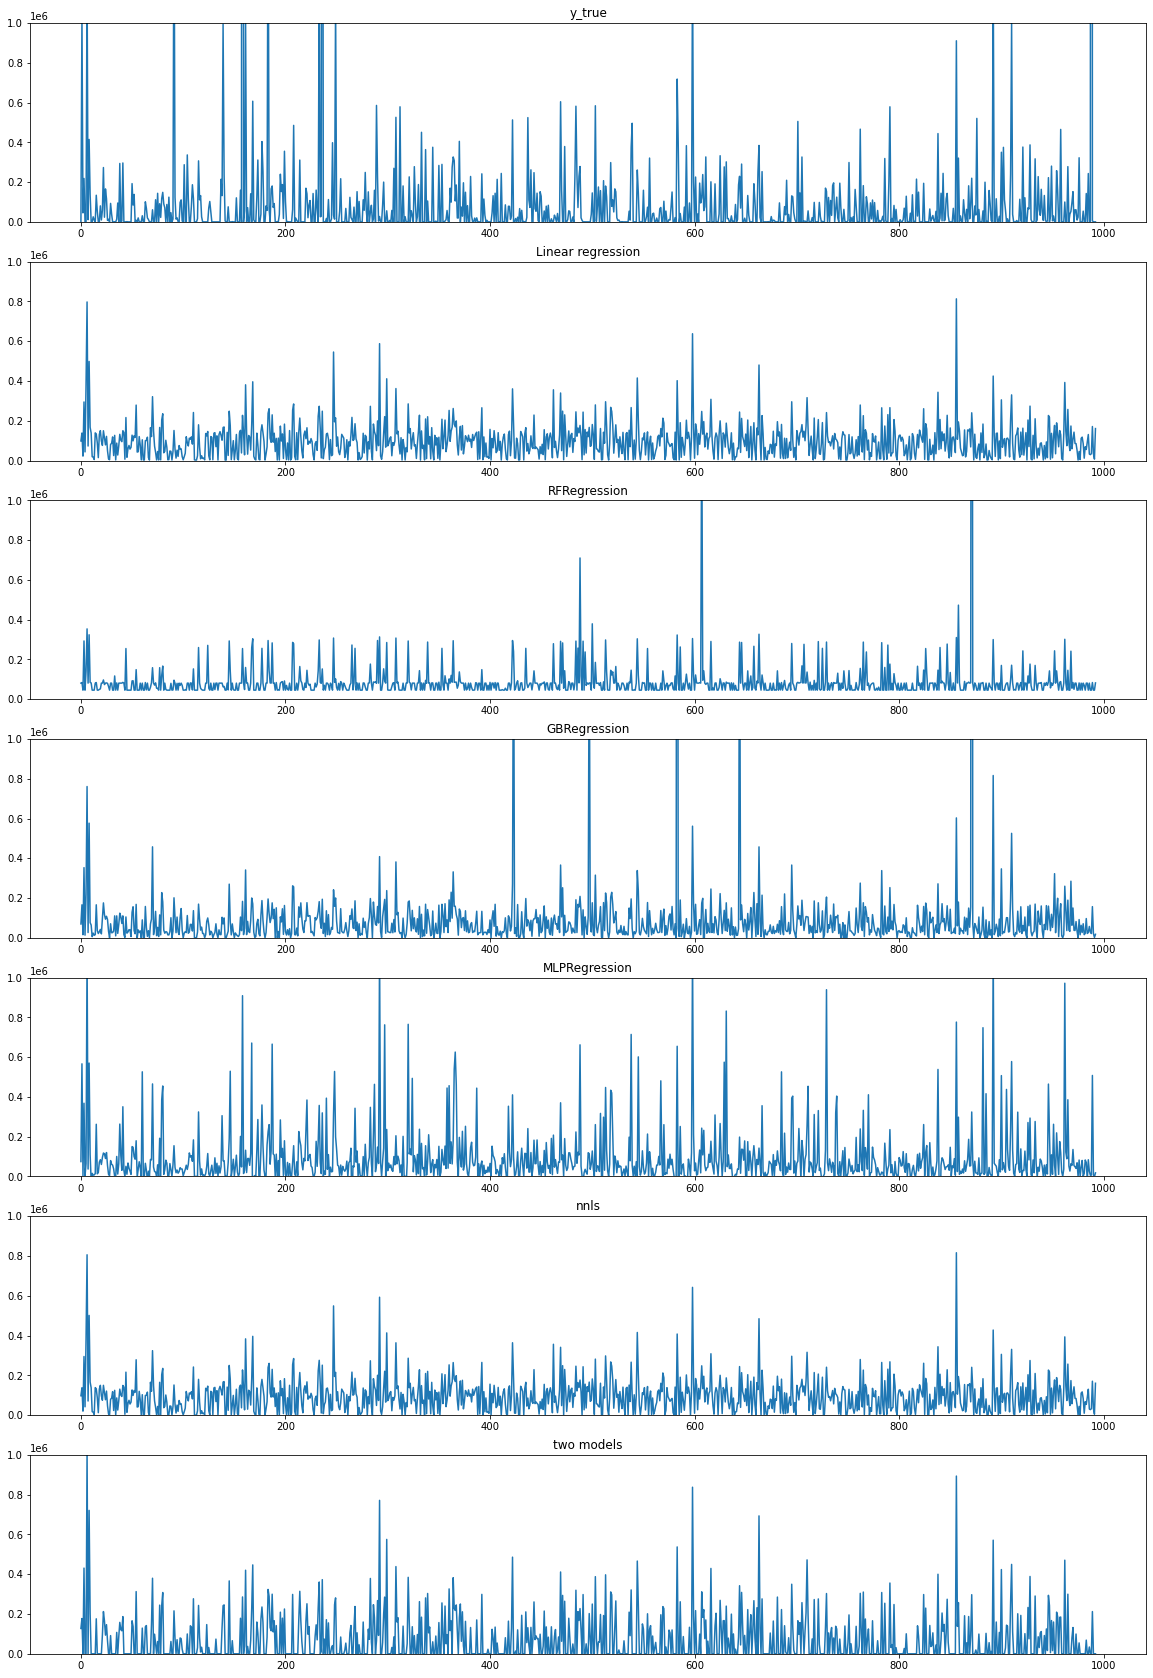

In [133]:
fig, ax = plt.subplots(7,1, figsize = (20,30))
ax[0].plot(np.arange(0,len(X_test)), y_test)
ax[1].plot(np.arange(0,len(X_test)), LR_pred)
ax[2].plot(np.arange(0,len(X_test)), RFR_pred)
ax[3].plot(np.arange(0,len(X_test)), GBR_pred)
ax[4].plot(np.arange(0,len(X_test)), MLPR_pred)
ax[5].plot(np.arange(0,len(X_test)), nnls_pred)
ax[6].plot(np.arange(0,len(X_test)), y_pred)

ax[0].set_ylim(0,1000000)
ax[1].set_ylim(0,1000000)
ax[2].set_ylim(0,1000000)
ax[3].set_ylim(0,1000000)
ax[4].set_ylim(0,1000000)
ax[5].set_ylim(0,1000000)
ax[6].set_ylim(0,1000000)

ax[0].set_title('y_true')
ax[1].set_title('Linear regression')
ax[2].set_title('RFRegression')
ax[3].set_title('GBRegression')
ax[4].set_title('MLPRegression')
ax[5].set_title('nnls')
ax[6].set_title('two models')

Text(0.5, 1.0, 'two models')

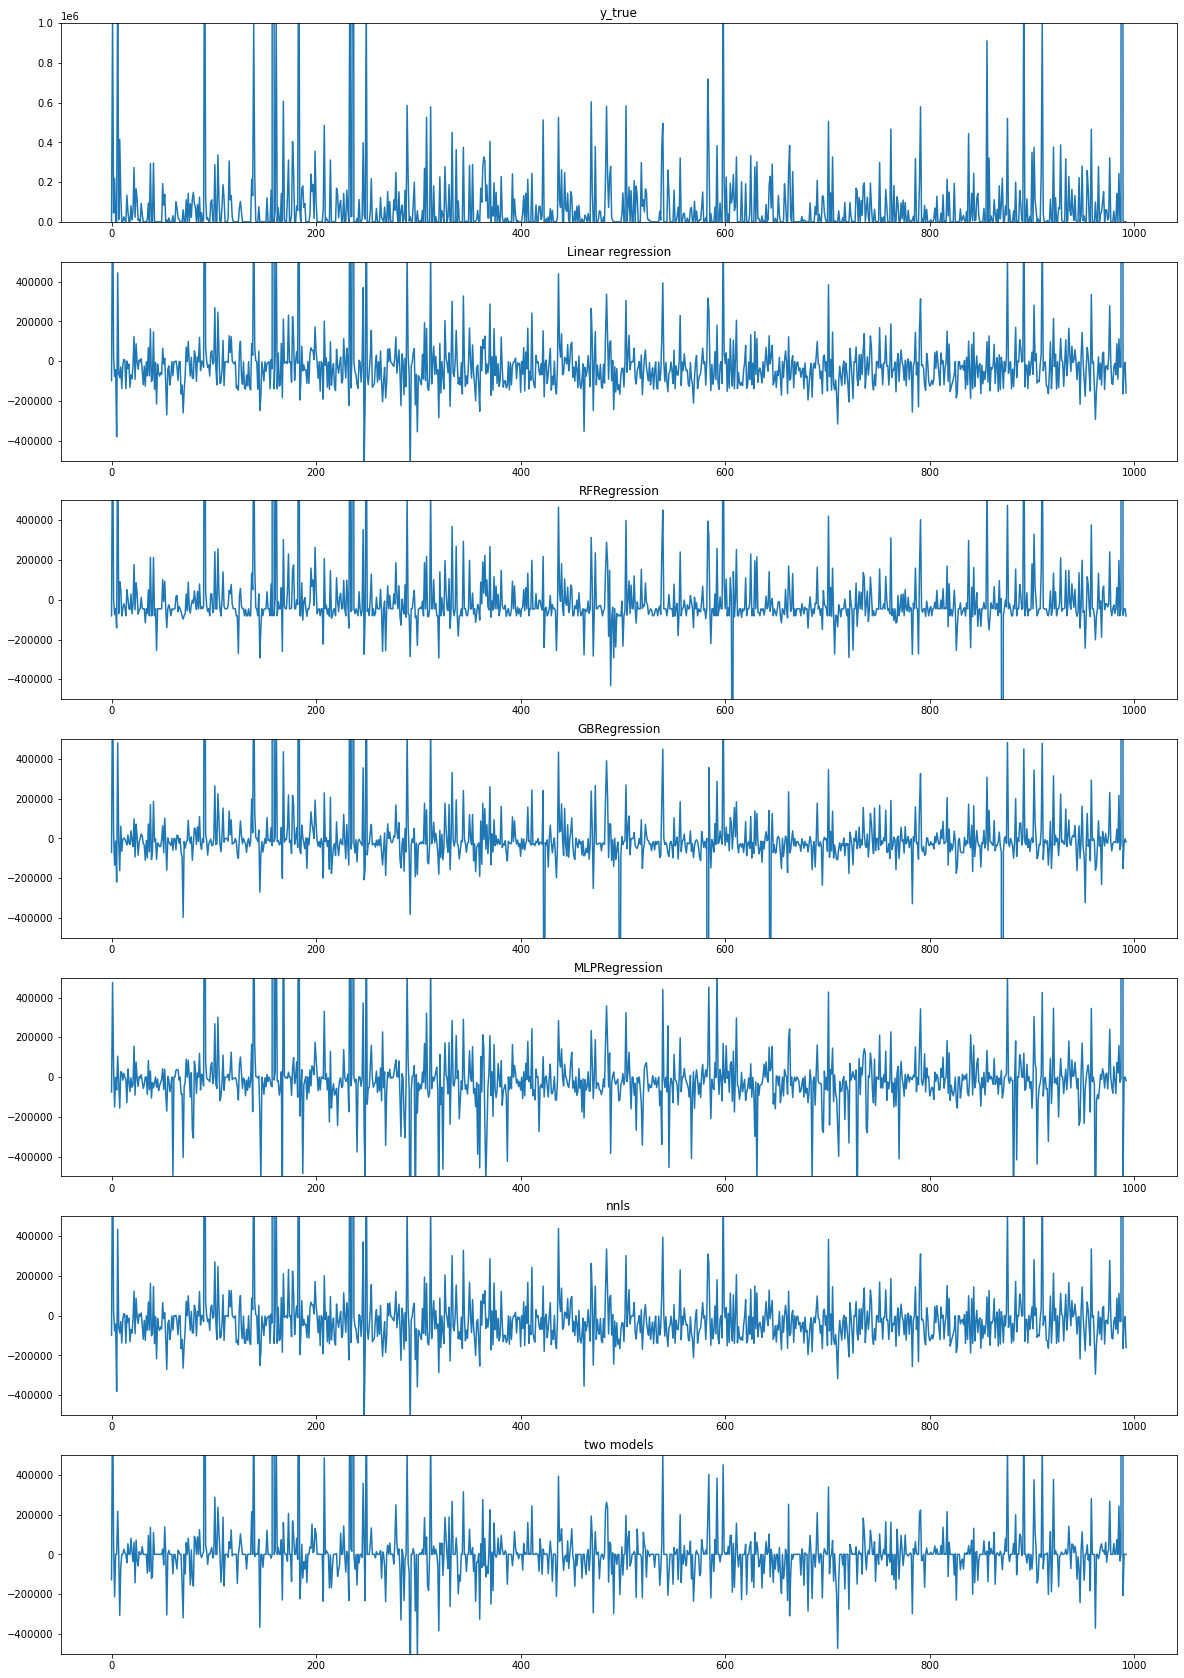

In [125]:
fig, ax = plt.subplots(7,1, figsize = (20,30))
ax[0].plot(np.arange(0,len(X_test)), y_test)
ax[1].plot(np.arange(0,len(X_test)), y_test.to_numpy() - LR_pred)
ax[2].plot(np.arange(0,len(X_test)), y_test.to_numpy() - RFR_pred)
ax[3].plot(np.arange(0,len(X_test)), y_test.to_numpy() - GBR_pred)
ax[4].plot(np.arange(0,len(X_test)), y_test.to_numpy() - MLPR_pred)
ax[5].plot(np.arange(0,len(X_test)), y_test.to_numpy() - nnls_pred)
ax[6].plot(np.arange(0,len(X_test)), y_test.to_numpy() - y_pred)

ax[0].set_ylim(0,1000000)
ax[1].set_ylim(-500000,500000)
ax[2].set_ylim(-500000,500000)
ax[3].set_ylim(-500000,500000)
ax[4].set_ylim(-500000,500000)
ax[5].set_ylim(-500000,500000)
ax[6].set_ylim(-500000,500000)

ax[0].set_title('y_true')
ax[1].set_title('Linear regression')
ax[2].set_title('RFRegression')
ax[3].set_title('GBRegression')
ax[4].set_title('MLPRegression')
ax[5].set_title('nnls')
ax[6].set_title('two models')

Предсказано с ошибкой меньше, чем 5000 из 993
LR 124
nnls 132
MLPR 153
2stage 431


(0.0, 2000000.0)

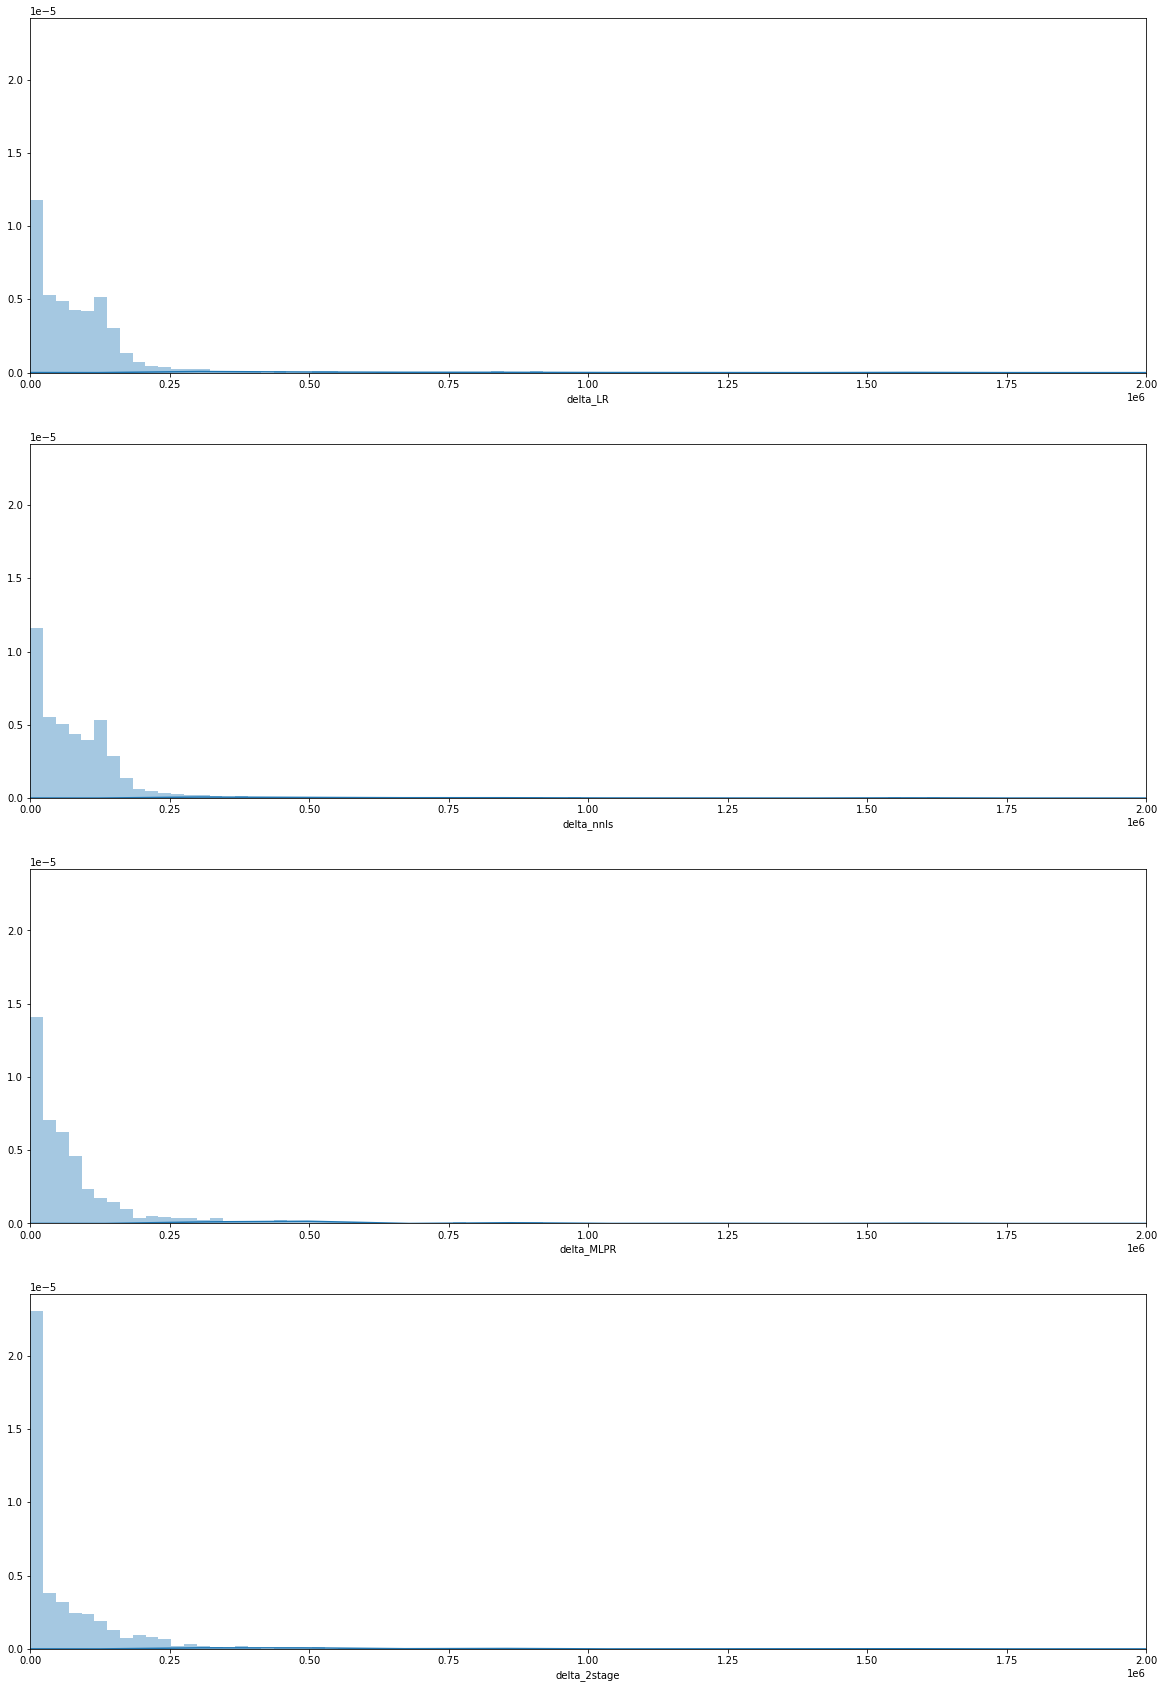

In [126]:
up = 400000
down = 5000 # 10000 - 231rows предсказано с меньшей ошибкой

res = pd.DataFrame(y_test)
res['LR'] = LR_pred
res['delta_LR'] = abs(res['target_sum'] - res['LR'])
res['nnls'] = nnls_pred
res['delta_nnls'] = abs(res['target_sum'] - res['nnls'])
res['MLPR'] = MLPR_pred
res['delta_MLPR'] = abs(res['target_sum'] - res['MLPR'])
res['2stage'] = y_pred
res['delta_2stage'] = abs(res['target_sum'] - res['2stage'])
print('Предсказано с ошибкой меньше, чем', down, 'из', len(y_test))
print('LR',len(res[(res['delta_LR'] < down)]))
print('nnls',len(res[(res['delta_nnls'] < down)]))
print('MLPR',len(res[(res['delta_MLPR'] < down)]))
print('2stage',len(res[(res['delta_2stage'] < down)]))

import seaborn as sns
fig, ax = plt.subplots(4,1,figsize=((20,30)), sharey=True)
sns.distplot(res['delta_LR'], ax=ax[0], bins=1000)
sns.distplot(res['delta_nnls'], ax=ax[1], bins=1000)
sns.distplot(res['delta_MLPR'], ax=ax[2], bins=1000)
sns.distplot(res['delta_2stage'], ax=ax[3], bins=1000)

ax[0].set_xlim(0,2000000)
ax[1].set_xlim(0,2000000)
ax[2].set_xlim(0,2000000)
ax[3].set_xlim(0,2000000)


#res[(res['delta_LR'] > up) | (res['delta_nnls'] > up) | (res['delta_MLPR'] > up)][['target_sum', 'delta_LR', 'delta_nnls', 'delta_MLPR']]
#res[(res['delta_LR'] < down) | (res['delta_nnls'] < down) | (res['delta_MLPR'] < down)][['target_sum', 'delta_LR', 'delta_nnls', 'delta_MLPR', 'delta_2stage', '2stage']]

## Со стандартизацией

In [127]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = train_tf[train_tf['target_sum'] != 0].drop(axis=1, labels=['cl_id', 'target_sum'])
y = train_tf[train_tf['target_sum'] != 0].target_sum.to_numpy().reshape(-1, 1)
scaler_X.fit_transform(X)
scaler_y.fit_transform(y)
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X, y, test_size=0.2, random_state=10)

# Прогнозируем тестовую выборку

In [128]:
test.head(20)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS
5,01/03/2017,2,5977,NaN,810,24MAR17:00:00:00,833.00,POS
6,01/04/2017,2,5812,NaN,810,24APR17:00:00:00,196.00,POS
7,01/03/2017,2,6011,NaN,810,28MAR17:00:00:00,2000.00,WD_ATM_PARTNER
8,01/04/2017,2,5912,NaN,810,08APR17:00:00:00,831.30,POS
9,01/04/2017,2,5651,NaN,810,27APR17:00:00:00,998.00,POS


## Готовим выборку

In [129]:
test = test2.copy()
test = test[test['currency'] == 810]
test = MakeDateYearMonth(test, 'PERIOD')
group_list = ['cl_id', 'year', 'month']
ser_ts_sum = test[['cl_id', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).first().astype('float64')
ser_pos_amount_sum = groupbysum(test[test['trx_category'] == 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_pos')
'''ser_notpos_amount_sum = groupbysum(test[test['trx_category'] != 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_notpos')
ser_pos_count = groupbycount(test[test['trx_category'] == 'POS'][['cl_id', 'year', 'month']],
                       group_list,
                       'cl_id',
                       'count_pos')
ser_notpos_count = groupbycount(test[test['trx_category'] != 'POS'][['cl_id','year', 'month']],
                       group_list,
                       'cl_id',
                       'count_notpos')'''

test = DfLeftJoinSer(test.drop(axis=1, labels=['PERIOD','MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category']).drop_duplicates(),
                      #[ser_ts_sum, ser_pos_amount_sum, ser_notpos_amount_sum, ser_pos_count, ser_notpos_count],
                     [ser_ts_sum, ser_pos_amount_sum],
                      ['cl_id', 'year', 'month'])

test_tf = pd.DataFrame(columns=['cl_id'])
for i in test.cl_id.unique():
    test_tf = test_tf.append(test[test['cl_id'] == i][['cl_id']].iloc[0])
test_tf = test_tf.astype({'cl_id': 'int64'})
    
for mon in range(1,max_mon): # 14+1
    test_tf[f'_{mon}_sum_pos'] = np.NaN
    #test_tf[f'_{mon}_sum_notpos'] = np.NaN
    #test_tf[f'_{mon}_count_pos'] = np.NaN
    #test_tf[f'_{mon}_count_notpos'] = np.NaN
    
test = test.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False]) 
for ind in test_tf.index:
    mon = 1
    temp_id = test_tf.loc[ind].cl_id
    for ji in test[test['cl_id'] == temp_id].index:
        test_tf.loc[ind,f'_{mon}_sum_pos'] = test.loc[ji,'sum_pos']
        #test_tf.loc[ind,f'_{mon}_sum_notpos'] = test.loc[ji,'sum_notpos']
        #test_tf.loc[ind,f'_{mon}_count_pos'] = test.loc[ji,'count_pos']
        #test_tf.loc[ind,f'_{mon}_count_notpos'] = test.loc[ji,'count_notpos']
        mon+=1
test_tf.fillna(0, inplace=True)
test_tf.head()    

,cl_id,_1_sum_pos,_2_sum_pos,_3_sum_pos,_4_sum_pos,_5_sum_pos,_6_sum_pos,_7_sum_pos,_8_sum_pos,_9_sum_pos,_10_sum_pos,_11_sum_pos,_12_sum_pos,_13_sum_pos,_14_sum_pos
0,2,18153.80,75492.80,48191.96,47239.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,3,21351.15,44330.00,49964.94,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,4,749.00,190511.50,93676.26,104.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,6,344.00,49489.40,75271.66,64451.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,7,31453.51,28330.34,22996.91,12017.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
test_tf

,cl_id,_1_sum_pos,_2_sum_pos,_3_sum_pos,_4_sum_pos,_5_sum_pos,_6_sum_pos,_7_sum_pos,_8_sum_pos,_9_sum_pos,_10_sum_pos,_11_sum_pos,_12_sum_pos,_13_sum_pos,_14_sum_pos
0,2,18153.80,75492.80,48191.96,47239.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,3,21351.15,44330.00,49964.94,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,4,749.00,190511.50,93676.26,104.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,6,344.00,49489.40,75271.66,64451.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,7,31453.51,28330.34,22996.91,12017.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874,8,42744.85,49310.70,73316.64,20888.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1072,12,4582.50,22508.11,20169.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1088,13,70411.56,69088.86,71442.49,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1198,15,1350.00,900.00,3845.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1210,16,71428.84,71427.82,72785.39,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Прогоняем через модель

In [131]:
columns_take = ['_1_sum_pos', '_2_sum_pos', '_3_sum_pos', '_4_sum_pos']
test_X_mod = test_tf.drop(axis=1, labels=['cl_id'])[columns_take].copy()
test_X_mod_cd = test_X_mod.copy()
test_GBC_pred = GBC.predict(test_X_mod)
test_X_mod_cd['classified'] = test_GBC_pred
test_nnls_pred_2nd = test_X_mod.apply(lambda row: np.sum(row.to_numpy()*nnls_sv_2nd), axis=1)
test_X_mod_cd['regression'] = test_nnls_pred_2nd
test_X_mod_cd['predicted'] = test_X_mod_cd.apply(lambda row: 0 if (row['classified']==0) else row['regression'], axis=1)
test_y_pred = test_X_mod_cd['predicted']
test_y_pred

0         134391.884279
199            0.000000
295       139367.229679
453            0.000000
702        77699.454457
874       158735.557530
1072           0.000000
1088           0.000000
1198           0.000000
1210           0.000000
1220           0.000000
1378           0.000000
1384           0.000000
1408           0.000000
1467           0.000000
1471           0.000000
1580           0.000000
1586      126744.627211
1730           0.000000
1879           0.000000
1895       90027.791135
2008           0.000000
2063           0.000000
2131           0.000000
2143           0.000000
2155       94434.586874
2280      442714.438989
2315           0.000000
2326      169677.542379
2528       53318.973818
              ...      
514137         0.000000
514209         0.000000
514577         0.000000
514580         0.000000
515563         0.000000
515901         0.000000
515907         0.000000
515916         0.000000
515928         0.000000
515962    140096.973884
515974         0

In [132]:
test_res = pd.DataFrame(test_tf['cl_id'].copy())
test_res['target_sum'] = test_y_pred
test_res[['cl_id', 'target_sum']].to_csv('test_result.csv', index=False)
test_res.head()

,cl_id,target_sum
0,2,134391.884279
199,3,0.000000
295,4,139367.229679
453,6,0.000000
702,7,77699.454457
